# Investigating the Data Stream: Identifying Module Clusters

Our high-level goal is to come up with ways to raise awareness of high-quality learning modules. One preliminary building block for this goal is to identify module clusters, or groups of modules that have similar or complementary content.

[Previously](https://github.com/cwivagg/iiab_analytics/blob/main/notebooks/notebook20211222.md), we pulled some issue logs from the Internet-in-a-Box repository. The basic unit of data we isolated was the ```menu.json``` file submitted with some issue requests. Within the ```menu.json``` file is a list of the modules that the user submitting the issue has selected for their local copy of Internet-in-a-Box.

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

DATA_HOME = "../.." # Just a local directory where we put the previous notebook entry's data.

menus = []
with open(os.path.join(DATA_HOME, "menus.json")) as f:
    for line in f:
        menu = json.loads(line)["menu_items_1"]
        menus.append(menu)

print("Example menu:\n\n" + str(menus[0]))

Example menu:

['en-oob', 'en-sample', 'en-test_zim', 'en-test_mod', 'en-map_admin', 'en-osm_viewer_v2', 'en-usb', 'en-kalite', 'en-raspberrypi_stackexchange_com_en_all', 'en-wikiquote_en_all_nopic', 'en-wiktionary_en_all_nopic', 'en-wikipedia_en_all_nopic', 'en-musictheory', 'en-olpc', 'en-asst_medical', 'en-math_expression', 'en-rpi_guide', 'en-peacebuilding', 'en-understanding_algebra', 'en-scratch', 'en-wikem', 'en-ebooks', 'en-practical_action', 'en-siyavula', 'en-algebra2go', 'en-boundless', 'en-credits']


We'll focus on English modules for now, since most of the issues submitted have ```menu.json``` files containing exclusively English modules.

In [2]:
from collections import Counter

def count_languages(menu):
    languages = [module[:2] for module in menu]
    return Counter(languages)

def find_majority_language(menu):
    language_dict = count_languages(menu)
    return max(language_dict, key=language_dict.get)

english_menus = []
for menu in menus:
    if find_majority_language(menu) == "en":
        english_menus.append(menu)
print("Found {} English menus".format(len(english_menus)))

Found 18 English menus


To find module clusters, we'll make use of a concept from the recommendations field, the item-item matrix. An item-item matrix counts the number of times two modules are chosen by the same user. The underlying assumption is that a group, or cluster, of modules consistently chosen by the same group of users must be related in some way. Here, we'll save the item-item matrix in the variable ```Xc```.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

trunc = 3 # Just a constant to control how much we print out.

cts = CountVectorizer(analyzer=lambda x: x)
X = cts.fit_transform(english_menus)

demo_df = pd.DataFrame(X.toarray()[:trunc,:trunc],
                       index=["menu 1", "menu 2", "menu 3"],
                       columns=cts.get_feature_names_out()[:trunc])
print("X looks like:")
print(demo_df)

Xc = (X.T * X).toarray()
Xc_labels = cts.get_feature_names_out()

demo_df = pd.DataFrame(Xc[:trunc,:trunc],
                       index=Xc_labels[:trunc],
                       columns=Xc_labels[:trunc])
print("\n\nXc looks like:")
print(demo_df)

X looks like:
        en-PhET  en-afristory  en-algebra2go
menu 1        0             0              1
menu 2        0             1              0
menu 3        0             0              0


Xc looks like:
               en-PhET  en-afristory  en-algebra2go
en-PhET              3             3              1
en-afristory         3             4              1
en-algebra2go        1             1              2


We can read this output like so: for the *i*th row and *j*th column, the matrix entry represents the number of times the *i*th and *j*th modules were selected together. So, en-PhET and en-algebra2go occurred in exactly one ```menu.json``` together, while en-PhET and en-afristory occurred in three ```menu.json``` lists together. The main diagonal is the number of times each module co-occurs with itself, or in other words, the total number of users that selected that module. So en-PhET was selected three times, en-afristory four, and en-algebra2go two.

Now, we'll start using the item-item matrix to determine how similar each item is. We can think of each row of the matrix as a vector, and to measure similarity, we'll compute the distance between the vectors. The lower the distance between two vectors, the greater their similarity is.

<AxesSubplot:>

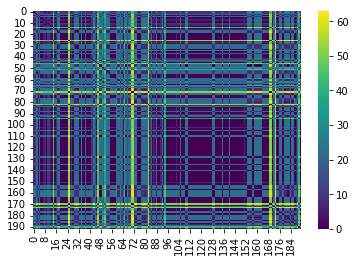

In [4]:
from scipy.spatial.distance import pdist, squareform

distance_matrix = squareform(pdist(Xc))

sns.heatmap(distance_matrix, cmap="viridis")

Euclidean distance is a more standard choice than cosine similarity for this application. In [some earlier experimentation](https://github.com/cwivagg/iiab_analytics/blob/main/notebooks/notebook_early-issues-visualization.ipynb), we also tried standardized Euclidean distance and cosine similarity gave reasonable results. Neither gave clearly better results, so we decided to stick with the standard choice.

<AxesSubplot:>

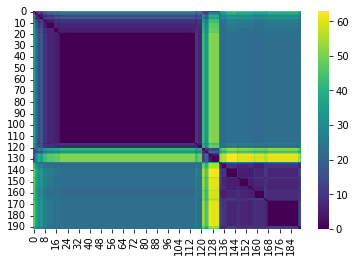

In [5]:
from scipy.cluster.hierarchy import linkage

visual_clusters = sns.clustermap(Xc, row_linkage=linkage(Xc), col_linkage=linkage(Xc))
plt.close() # Seaborn has a nice display once it's done clustering, but we'll use our own so we can keep it consistent
            # with our other visualizations.

row_ix = visual_clusters.dendrogram_row.reordered_ind
col_ix = visual_clusters.dendrogram_col.reordered_ind

sns.heatmap(distance_matrix[row_ix][:,col_ix], cmap="viridis")

Above, we just visualized rearranged the order of items in the distance matrix to put nearby things close together. Clusters of items that are close together appear as dark blue squares.

The only thing we need now to find an algorithmic way of deciding what is a dark blue square and what is not: for instance, where exactly are the borders of the big square in the upper left corner? The simplest way of finding out is using a distance threshold to say that items below *x* distance apart are connected, and items above *x* distance apart are not. Then, the distance matrix becomes an adjacency matrix, and the clusters are the [transitive closure](https://en.wikipedia.org/wiki/Transitive_closure) of the graph that the adjacency matrix represents.

This approach can be a little brittle and lead to connecting too many things, but it turned out to be good enough for this data.

<AxesSubplot:>

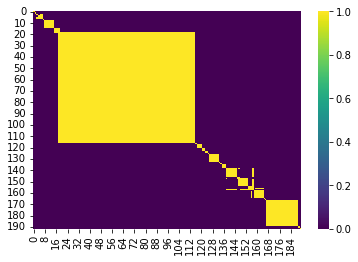

In [6]:
from scipy.sparse import csr_matrix

threshold = 5 # The threshold can be manually tuned to get good results.

zs = distance_matrix > threshold
os = distance_matrix <= threshold
distance_matrix[zs] = 0
distance_matrix[os] = 1

sns.heatmap(distance_matrix[row_ix][:,col_ix], cmap="viridis")

In [7]:
from scipy.sparse.csgraph import connected_components

n_components, labels = connected_components(csgraph=csr_matrix(distance_matrix), directed=False)

components = []
for ix in range(n_components):
    component = Xc_labels[labels==ix]
    components.append(component)

Finally, for our demonstration use case, we'll imagine that we want to construct a "small", "medium", and "large" set of modules that the average Internet-in-a-Box user might find useful. We'll assume that the most popular clusters, defined as the clusters with the highest average interaction count for their constituent modules, are the ones that should go in the sets, with the larger sets containing progressively less popular clusters.

Let's take a look at some of the popular clusters.

In [8]:
def get_cluster_average_count(list_of_labels):
    """
    Given a list of modules, retrieves the count of each module from the main diagonal of Xc. Returns the average
    count of the list.
    """
    Xc_labels_list = list(Xc_labels)
    s = 0
    for label in list_of_labels:
        ix = Xc_labels_list.index(label)
        s += Xc[ix,ix]
    return s / len(list_of_labels)

trunc = 9 # Just a constant to control how much we print out.

components.sort(key = lambda x: get_cluster_average_count(x))
for component in components[-trunc:]:
    print("{:.1f} - {}".format(get_cluster_average_count(component), component))

4.0 - ['en-understanding_algebra']
5.8 - ['en-internetarchive' 'en-lokole' 'en-mediawiki' 'en-moodle' 'en-nodered']
7.0 - ['en-elgg']
9.0 - ['en-kolibri']
10.5 - ['en-nextcloud' 'en-sugarizer']
13.0 - ['en-map_admin']
13.5 - ['en-calibreweb' 'en-wordpress']
15.0 - ['en-kalite']
17.3 - ['en-credits' 'en-oob' 'en-osm_viewer_v2' 'en-sample' 'en-test_mod'
 'en-test_zim' 'en-usb']


The popular clusters give groups of modules that are similar, but not identical to the modules we would have chosen if we had just ranked the modules by popularity. The clustering approach will tend to elevate modules that are chosen by users who tend to pick popular modules over modules that are chosen by a large minority who *don't* choose popular modules. In the list above, we can see 'en-mediawiki' being pushed down the list below 'en-elgg' due to this effect.

In [9]:
ct_sums = np.sum(X.toarray(),axis=0)

trunc = 21

for ix, ele in enumerate([(x, y) for y, x in sorted(zip(ct_sums, Xc_labels))][-trunc:]):
    print("{} - {}".format(ele[1], ele[0]))

4 - en-understanding_algebra
5 - en-internetarchive
5 - en-nodered
6 - en-lokole
6 - en-moodle
7 - en-elgg
7 - en-mediawiki
9 - en-kolibri
10 - en-nextcloud
11 - en-sugarizer
13 - en-map_admin
13 - en-wordpress
14 - en-calibreweb
15 - en-kalite
17 - en-oob
17 - en-osm_viewer_v2
17 - en-sample
17 - en-test_mod
17 - en-test_zim
18 - en-credits
18 - en-usb


Now we just decide how many clusters to include in our module sets.

In [10]:
S = ("S", 1)
M = ("M", 4)
L = ("L", 14)

def print_module_selection(module_selection_tuple):
    name, size = module_selection_tuple[0], module_selection_tuple[1]
    print("{} module grouping:\n".format(name))
    modules = []
    for module_cluster in components[-size:]:
        modules += list(module_cluster)
    for module in modules:
        print(module)

Here's the large set!

In [11]:
print_module_selection(L)

L module grouping:

en-wikem
en-hesperian_health
en-stanford_em
en-ted_en_playlist-10-ideas-for-ending-hiv-aids
en-ted_en_playlist-how-your-brain-constructs-real
en-PhET
en-afristory
en-binofino
en-blockly-games
en-bookdash
en-catdogbooks
en-saylor
en-cups
en-healthphone
en-understanding_algebra
en-internetarchive
en-lokole
en-mediawiki
en-moodle
en-nodered
en-elgg
en-kolibri
en-nextcloud
en-sugarizer
en-map_admin
en-calibreweb
en-wordpress
en-kalite
en-credits
en-oob
en-osm_viewer_v2
en-sample
en-test_mod
en-test_zim
en-usb
